In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, LSTM, TimeDistributed, Flatten, Dropout
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import normalize

In [59]:
def augFeatures(data):
    data['Date'] = pd.to_datetime(data['Date'])
    data['year'] = data['Date'].dt.year
    data['month'] = data['Date'].dt.month
    data['day'] = data['Date'].dt.day
    data['week'] = data['Date'].dt.dayofweek
    data = data.drop(['Date'], axis=1)
    return data

In [60]:
data = pd.read_csv('6269_adapt.csv')
stock = pd.read_csv('stock_index.csv')
stock = stock.rename(columns={'Open':'s_open', 'High':'s_high', 'Low':'s_low', 'Close':'s_close'})
stock = stock.drop(['Date'], axis=1)
train = pd.concat([data, stock], axis=1, join='inner')
train = augFeatures(train)

In [61]:
# build Data, use last 5 days to predict next 5 days
def buildTrain(Train, pastDay=5, futureDay=5):
    Y = Train['Close']
    X = Train.drop(['Close'], axis=1)
    X = normalize(X.values)
    x_test = X[Train.iloc[len(Train)-5:].index]
    x_train, y_train = [], []
    for i in range(Train.shape[0]-futureDay-pastDay):
        x_train.append(np.array(X[i:i+pastDay]))
        y_train.append(np.array(Y.iloc[i+pastDay:i+pastDay+futureDay]))
    return np.array(x_train), np.array(y_train), x_test

In [62]:
def shuffle(X,Y):
  np.random.seed(10)
  randomList = np.arange(X.shape[0])
  np.random.shuffle(randomList)
  return X[randomList], Y[randomList]

In [63]:
def splitData(X,Y,rate):
  x = int(X.shape[0]*rate)
  y = int(Y.shape[0]*rate)
  X_train = X[x:]
  Y_train = Y[y:]
  X_val = X[:x]
  Y_val = Y[:y]
  return X_train, Y_train, X_val, Y_val

In [64]:
# Build training data and normalization
X_train, Y_train, X_pre = buildTrain(train, pastDay=5, futureDay=5)

# Shuffle Data
X_train, Y_train = shuffle(X_train, Y_train)

# Split Data to training set and validation set
X_train, Y_train, X_val, Y_val = splitData(X_train, Y_train, 0.1)

In [65]:
# Build Model
def buildOneToOneModel(shape):
  model = Sequential()
  model.add(LSTM(units = 256, input_shape=(shape[1], shape[2]), return_sequences=True))
  model.add(Dropout(0.2))
  model.add(LSTM(units = 256, return_sequences=True))
  model.add(Dropout(0.2))
  # model.add(LSTM(units = 256, return_sequences=True))
  # model.add(Dropout(0.2))
  model.add(TimeDistributed(Dense(1)))
  model.add(Flatten())
  model.add(Dense(64, activation='linear'))
  model.add(Dense(32, activation='linear'))
  model.add(Dense(32, activation='relu'))
  # Add output layer
  model.add(Dense(5))
  # Compiling the RNN
  model.compile(loss="mean_absolute_error", optimizer="adam",metrics=['mean_absolute_error'])
  model.summary()
  return model

In [66]:
model = buildOneToOneModel(X_train.shape)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 5, 256)            274432    
_________________________________________________________________
dropout_9 (Dropout)          (None, 5, 256)            0         
_________________________________________________________________
lstm_10 (LSTM)               (None, 5, 256)            525312    
_________________________________________________________________
dropout_10 (Dropout)         (None, 5, 256)            0         
_________________________________________________________________
time_distributed_4 (TimeDist (None, 5, 1)              257       
_________________________________________________________________
flatten_4 (Flatten)          (None, 5)                 0         
_________________________________________________________________
dense_17 (Dense)             (None, 64)               

In [67]:
callback = EarlyStopping(monitor="loss", patience=10, verbose=1, mode="auto")
train_history = model.fit(X_train, Y_train, epochs=1000, batch_size=128, validation_data=(X_val, Y_val), callbacks=[callback])

Epoch 1/1000
31/31 [==============================] - 5s 80ms/step - loss: 52.2650 - mean_absolute_error: 52.2650 - val_loss: 38.6570 - val_mean_absolute_error: 38.6570
Epoch 2/1000
31/31 [==============================] - 2s 55ms/step - loss: 36.6658 - mean_absolute_error: 36.6658 - val_loss: 35.8138 - val_mean_absolute_error: 35.8138
Epoch 3/1000
31/31 [==============================] - 2s 60ms/step - loss: 35.0970 - mean_absolute_error: 35.0970 - val_loss: 35.9666 - val_mean_absolute_error: 35.9666
Epoch 4/1000
31/31 [==============================] - 2s 62ms/step - loss: 35.1409 - mean_absolute_error: 35.1409 - val_loss: 35.7788 - val_mean_absolute_error: 35.7788
Epoch 5/1000
31/31 [==============================] - 2s 59ms/step - loss: 35.0793 - mean_absolute_error: 35.0793 - val_loss: 35.6654 - val_mean_absolute_error: 35.6654
Epoch 6/1000
31/31 [==============================] - 2s 54ms/step - loss: 35.1787 - mean_absolute_error: 35.1787 - val_loss: 35.2235 - val_mean_absolute_e

In [68]:
# loss function
loss = train_history.history['loss']
val_loss = train_history.history['val_loss']

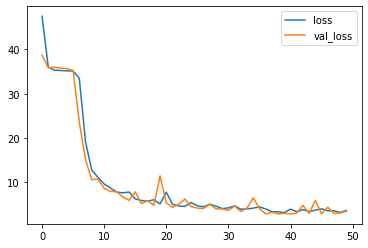

In [69]:
plt.plot(loss, label='loss')
plt.plot(val_loss, label='val_loss')
plt.legend()
plt.show()

In [73]:
# save my model
model.save('stock_lstm_v1.h5')

In [70]:
test = model.evaluate(X_val, Y_val, batch_size=128)
print('Test Result: ', test)

4/4 [==============================] - 0s 21ms/step - loss: 3.5036 - mean_absolute_error: 3.5036
Test Result:  [3.5036089420318604, 3.5036089420318604]


In [71]:
# Predict the future price with trained model
X_pre = np.array([X_pre])
print('Predict Result', model.predict(X_pre))

Predict Result [[123.25262  124.66886  124.978134 124.51701  124.59271 ]]
